# Agent

In [1]:
from environments.pika_env import PikaEnv
from environments.helper import open_game

class Config:
    def __init__(self):
        # environment
        self.base_address = 0x00002A88
        self.image_size = [84,84]
        self.interval_time = 0.2
        
        # model
        self.hidden_layer_size = 200
        self.learning_rate = 0.0005
        self.batch_size_episodes = 10
        self.load_checkpoint = "store_true"
        self.discount_factor = 0.99
        self.render = "store_true"

In [2]:
config = Config()

In [3]:
env = PikaEnv(config)

Found window : 0x000b04c0: '뫮먰귃궔궭귙?갏?拒걍艱微뺂( 긹??붎 )'


In [4]:
env.action.window_name

'뫮먰귃궔궭귙?갏?拒걍艱微뺂( 긹??붎 )'

In [5]:
env.reset_game()

In [14]:
from PIL import Image
import numpy as np

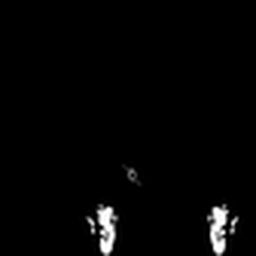

In [15]:
Image.fromarray(observation).resize([256, 256], Image.ANTIALIAS)

In [6]:
from __future__ import division

import gym
import numpy as np
import random
import tensorflow as tf
import tensorflow.contrib.slim as slim
import scipy.misc
import os

C:\Users\kang\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [7]:
class Qnetwork():
    def __init__(self,h_size):
        #The network recieves a frame from the game, flattened into an array.
        #It then resizes it and processes it through four convolutional layers.
        self.imageIn = tf.placeholder(shape=[None,84,84,3], dtype=tf.float32)
        self.conv1 = slim.conv2d( \
            inputs=self.imageIn,num_outputs=32,kernel_size=[8,8],stride=[4,4],padding='VALID', biases_initializer=None)
        self.conv2 = slim.conv2d( \
            inputs=self.conv1,num_outputs=64,kernel_size=[4,4],stride=[2,2],padding='VALID', biases_initializer=None)
        self.conv3 = slim.conv2d( \
            inputs=self.conv2,num_outputs=64,kernel_size=[3,3],stride=[1,1],padding='VALID', biases_initializer=None)
        self.conv4 = slim.conv2d( \
            inputs=self.conv3,num_outputs=h_size,kernel_size=[7,7],stride=[1,1],padding='VALID', biases_initializer=None)
        
        #We take the output from the final convolutional layer and split it into separate advantage and value streams.
        self.streamAC,self.streamVC = tf.split(self.conv4,2,3)
        self.streamA = slim.flatten(self.streamAC)
        self.streamV = slim.flatten(self.streamVC)
        xavier_init = tf.contrib.layers.xavier_initializer()
        self.AW = tf.Variable(xavier_init([h_size//2,env.actions]))
        self.VW = tf.Variable(xavier_init([h_size//2,1]))
        self.Advantage = tf.matmul(self.streamA,self.AW)
        self.Value = tf.matmul(self.streamV,self.VW)
        
        #Then combine them together to get our final Q-values.
        self.Qout = self.Value + tf.subtract(self.Advantage,tf.reduce_mean(self.Advantage,axis=1,keep_dims=True))
        self.predict = tf.argmax(self.Qout,1)
        
        #Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
        self.targetQ = tf.placeholder(shape=[None],dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions,env.actions,dtype=tf.float32)
        
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis=1)
        
        self.td_error = tf.square(self.targetQ - self.Q)
        self.loss = tf.reduce_mean(self.td_error)
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.updateModel = self.trainer.minimize(self.loss)

In [8]:
class experience_buffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
        self.buffer.extend(experience)
            
    def sample(self,size):
        return np.reshape(np.array(random.sample(self.buffer,size)),[size,5])

In [9]:
def updateTargetGraph(tfVars,tau):
    total_vars = len(tfVars)
    op_holder = []
    for idx,var in enumerate(tfVars[0:total_vars//2]):
        op_holder.append(tfVars[idx+total_vars//2].assign((var.value()*tau) + ((1-tau)*tfVars[idx+total_vars//2].value())))
    return op_holder

def updateTarget(op_holder,sess):
    for op in op_holder:

        sess.run(op)

In [82]:
batch_size = 32 #How many experiences to use for each training step.
update_freq = 4 #How often to perform a training step.
y = .99 #Discount factor on the target Q-values
startE = 1 #Starting chance of random action
endE = 0.1 #Final chance of random action
annealing_steps = 10000. #How many steps of training to reduce startE to endE.
num_episodes = 10000 #How many episodes of game environment to train network with.
pre_train_steps = 0 #How many steps of random actions before training begins.
memory_steps = 0
max_epLength = 50 #The max allowed length of our episode.
load_model = True #Whether to load a saved model.
path = "./dqn2" #The path to save our model to.
h_size = 512 #The size of the final convolutional layer before splitting it into Advantage and Value streams.
tau = 0.001 #Rate to update target network toward primary network

In [83]:
def smoothing(length, reward):
    decay_factor = 0.99
    return [decay_factor**(length-i-1)*reward for i in range(length)]

In [80]:
import time

In [81]:
tf.reset_default_graph()
mainQN = Qnetwork(h_size)
targetQN = Qnetwork(h_size)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

trainables = tf.trainable_variables()

targetOps = updateTargetGraph(trainables,tau)

# myBuffer = experience_buffer()

#Set the rate of random action decrease. 
e = startE
stepDrop = (startE - endE)/annealing_steps

#create lists to contain total rewards and steps per episode
jList = []
rList = []
total_steps = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path)

with tf.Session() as sess:
    sess.run(init)
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    for i in range(num_episodes):
        episodeBuffer = experience_buffer()
        #Reset environment and get first new observation
        env.reset_game()
        s, _, _, _ = env.step(0)
        d = 0
        rAll = 0
        j = 0
        #The Q-Network
        # 1 Episode
        while True:
            roundBuffer = experience_buffer()
            #Choose an action by greedily (with e chance of random action) from the Q-network
            if np.random.rand(1) < e or total_steps < pre_train_steps:
                a = np.random.randint(0,11)
            else:
                a = sess.run(mainQN.predict,feed_dict={mainQN.imageIn:[s]})[0]
            s1,r,d, _ = env.step(a)
            total_steps += 1
            roundBuffer.add(np.reshape(np.array([s,a,0,s1,d]),[1,5]))

            if total_steps > pre_train_steps+memory_steps:
                if e > endE:
                    e -= stepDrop

                if total_steps % (update_freq) == 0:
                    trainBatch = myBuffer.sample(batch_size) #Get a random batch of experiences.
                    #Below we perform the Double-DQN update to the target Q-values
                    Q1 = sess.run(mainQN.predict,feed_dict={mainQN.imageIn:np.stack(trainBatch[:,3])})
                    Q2 = sess.run(targetQN.Qout,feed_dict={targetQN.imageIn:np.stack(trainBatch[:,3])})
                    end_multiplier = -(trainBatch[:,4] - 1)
                    doubleQ = Q2[range(batch_size),Q1]
                    targetQ = trainBatch[:,2] + (y*doubleQ * end_multiplier)
                    #Update the network with our target values.
                    _ = sess.run(mainQN.updateModel, \
                        feed_dict={mainQN.imageIn:np.stack(trainBatch[:,0]),
                                   mainQN.targetQ:targetQ, 
                                   mainQN.actions:trainBatch[:,1]})

                    updateTarget(targetOps,sess) #Update the target network toward the primary network.
            elif total_steps > pre_train_steps:
                if e > endE:
                    e -= stepDrop

                if total_steps % (update_freq) == 0:
                    trainBatch = memoryBuffer.sample(batch_size) #Get a random batch of experiences.
                    #Below we perform the Double-DQN update to the target Q-values
                    Q1 = sess.run(mainQN.predict,feed_dict={mainQN.imageIn:np.stack(trainBatch[:,3])})
                    Q2 = sess.run(targetQN.Qout,feed_dict={targetQN.imageIn:np.stack(trainBatch[:,3])})
                    end_multiplier = -(trainBatch[:,4] - 1)
                    doubleQ = Q2[range(batch_size),Q1]
                    targetQ = trainBatch[:,2] + (y*doubleQ * end_multiplier)
                    #Update the network with our target values.
                    _ = sess.run(mainQN.updateModel, \
                        feed_dict={mainQN.imageIn:np.stack(trainBatch[:,0]),
                                   mainQN.targetQ:targetQ, 
                                   mainQN.actions:trainBatch[:,1]})

                    updateTarget(targetOps,sess) 
            if d==3:
                time.sleep(0.5)
                reward = env.get_reward()
                rAll += reward
                buffer = roundBuffer.buffer
                annealed_reward = smoothing(len(buffer), reward/2+len(buffer)/60)
                for idx, x in enumerate(annealed_reward):
                    buffer[idx][2] = x
                episodeBuffer.add(buffer)
                #continue

            s = s1

            if d==4:
                com_score, my_score = env.state.get_score()
                print("Episode {} Ended | Score {} : {}".format(i, com_score, my_score))
                break
        
        myBuffer.add(episodeBuffer.buffer)
        jList.append(j)
        rList.append(rAll)
        #Periodically save the model. 
        if i % 10 == 0:
            saver.save(sess,path+'/model-'+str(i)+'.ckpt')
            print("Saved Model")
        if len(rList) % 1 == 0:
            print(total_steps,np.mean(rList[-10:]), e)
    saver.save(sess,path+'/model-'+str(i)+'.ckpt')
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")

Loading Model...
INFO:tensorflow:Restoring parameters from ./dqn2\model-80.ckpt
Episode 0 Ended | Score 5 : 0
Saved Model
Episode 1 Ended | Score 5 : 0
Episode 2 Ended | Score 5 : 0
Episode 3 Ended | Score 5 : 0
Episode 4 Ended | Score 5 : 0
Episode 5 Ended | Score 5 : 0
Episode 6 Ended | Score 5 : 0
Episode 7 Ended | Score 5 : 0
Episode 8 Ended | Score 5 : 0
Episode 9 Ended | Score 5 : 0
447 0.0 1
Episode 10 Ended | Score 5 : 0
Saved Model
Episode 11 Ended | Score 5 : 0
Episode 12 Ended | Score 5 : 0
Episode 13 Ended | Score 5 : 0


KeyboardInterrupt: 

In [78]:
rAll

0

In [11]:
from pynput import keyboard

In [38]:
memoryBuffer = experience_buffer()

In [49]:
current=set()
already=False
## set "results" as a global variable
results=[]
s = env.get_states()

def on_press(key):
    global already
    global s
    try:
        if not key.char in current:
            current.add(key.char)
    except AttributeError:
        if str(key)=='Key.up':
            if 'Key.up' in current:
                already=True
            else:
                already=False
        
        if 'Key.enter' in current and str(key)=='Key.enter':
            current.remove('Key.enter')
        elif not str(key) in current:
            current.add(str(key))

    # kk=key)
    # kk=current)
    # spike
    if 'Key.enter' in current:
        if 'Key.up' in current:
            ## 9: UP & LEFT & SPIKE
            if 'Key.left' in current:
                kk=9
            ## 10: UP & RIGHT & SPIKE
            elif 'Key.right' in current:
                kk=10
            ##  6: UP & SPIKE
            else:
                kk=6
        elif 'Key.down' in current:
            ## 11: DOWN & (LEFT | RIGHT) & SPIKE
            if 'Key.left' in current or 'Key.right' in current:
                kk=11
            ##  8: DOWN & SPIKE
            else:
                kk=8
        else:
            ## 5: LEFT & SPIKE
            if 'Key.left' in current:
                kk=5
            ## 7: RIGHT & SPIKE
            elif 'Key.right' in current:
                kk=7
            ## 0: SPIKE
            else:
                kk=0

    ## non-spike
    else:
        ## 1: UP
        if 'Key.up' in current and not already:
            kk=1
        ## 3: LEFT 
        elif 'Key.left' in current:
            kk=3
        ## 4: RIGHT
        elif 'Key.right' in current:
            kk=4
        ## 2: NO ACTION
        else:
            kk=2

    s1 = env.get_states()
    memoryBuffer.add(np.reshape([s, kk, 0.8, s1, 1], [1,5]))
    s = s1

def on_release(key):
    try:
        if key.char in current:
            current.remove(key.char)
    except AttributeError:
        if str(key) in current:
            current.remove(str(key))
    if key == keyboard.Key.esc:
        # Stop listener
        return False

# Collect events until released
with keyboard.Listener(
        on_press=on_press,
        on_release=on_release) as listener:
    s = env.get_states()
    listener.join()

In [50]:
len(memoryBuffer.buffer)

3094

In [30]:
buffer = memoryBuffer.buffer
for b in buffer:
    b[2]=0.8
    memoryBuffer.add(b)

In [53]:
batch_size = 32 #How many experiences to use for each training step.
update_freq = 4 #How often to perform a training step.
y = .99 #Discount factor on the target Q-values
startE = 1.0 #Starting chance of random action
endE = 0.1 #Final chance of random action
annealing_steps = 8000. #How many steps of training to reduce startE to endE.
num_episodes = 500 #How many episodes of game environment to train network with.
pre_train_steps = 500 #How many steps of random actions before training begins.
max_epLength = 50 #The max allowed length of our episode.
load_model = True #Whether to load a saved model.
path = "./dqn" #The path to save our model to.
h_size = 512 #The size of the final convolutional layer before splitting it into Advantage and Value streams.
tau = 0.001 #Rate to update target network toward primary network

In [58]:
tf.reset_default_graph()
mainQN = Qnetwork(h_size)
targetQN = Qnetwork(h_size)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

trainables = tf.trainable_variables()

targetOps = updateTargetGraph(trainables,tau)

myBuffer = experience_buffer()
myBuffer.add(memoryBuffer.buffer)

#Set the rate of random action decrease. 
e = startE
stepDrop = (startE - endE)/annealing_steps

#create lists to contain total rewards and steps per episode
jList = []
rList = []
total_steps = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path)

with tf.Session() as sess:
    sess.run(init)
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    for i in range(num_episodes):
        episodeBuffer = experience_buffer()
        #Reset environment and get first new observation
        env.reset_game()
        s, _, _, _ = env.step(0)
        d = 0
        rAll = 0
        j = 0
        #The Q-Network
        # 1 Episode
        while True:
            roundBuffer = experience_buffer()
            #Choose an action by greedily (with e chance of random action) from the Q-network
            if np.random.rand(1) < e or total_steps < pre_train_steps:
                a = np.random.randint(0,11)
            else:
                a = sess.run(mainQN.predict,feed_dict={mainQN.imageIn:[s]})[0]
            s1,r,d, _ = env.step(a)
            total_steps += 1
            roundBuffer.add(np.reshape(np.array([s,a,0,s1,d]),[1,5]))

            if total_steps > pre_train_steps:
                if e > endE:
                    e -= stepDrop

                if total_steps % (update_freq) == 0:
                    trainBatch = myBuffer.sample(batch_size) #Get a random batch of experiences.
                    #Below we perform the Double-DQN update to the target Q-values
                    Q1 = sess.run(mainQN.predict,feed_dict={mainQN.imageIn:np.stack(trainBatch[:,3])})
                    Q2 = sess.run(targetQN.Qout,feed_dict={targetQN.imageIn:np.stack(trainBatch[:,3])})
                    end_multiplier = -(trainBatch[:,4] - 1)
                    doubleQ = Q2[range(batch_size),Q1]
                    targetQ = trainBatch[:,2] + (y*doubleQ * end_multiplier)
                    #Update the network with our target values.
                    _ = sess.run(mainQN.updateModel, \
                        feed_dict={mainQN.imageIn:np.stack(trainBatch[:,0]),
                                   mainQN.targetQ:targetQ, 
                                   mainQN.actions:trainBatch[:,1]})

                    updateTarget(targetOps,sess) #Update the target network toward the primary network.

            if d==3:
                reward = env.get_reward()
                rAll += reward
                buffer = roundBuffer.buffer
                annealed_reward = smoothing(len(buffer), reward)
                for idx, x in enumerate(annealed_reward):
                    buffer[idx][2] = x
                episodeBuffer.add(buffer)
                continue

            s = s1

            if d==4:
                com_score, my_score = env.state.get_score()
                print("Episode {} Ended | Score {} : {}".format(i, com_score, my_score))
                break
        
        myBuffer.add(episodeBuffer.buffer)
        jList.append(j)
        rList.append(rAll)
        #Periodically save the model. 
        if i % 10 == 0:
            saver.save(sess,path+'/model-'+str(i)+'.ckpt')
            print("Saved Model")
        if len(rList) % 10 == 0:
            print(total_steps,np.mean(rList[-10:]), e)
    saver.save(sess,path+'/model-'+str(i)+'.ckpt')
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")

Loading Model...
INFO:tensorflow:Restoring parameters from ./dqn\model-0.ckpt
Episode 0 Ended | Score 5 : 1
Saved Model
Episode 1 Ended | Score 5 : 1
Episode 2 Ended | Score 5 : 0
Episode 3 Ended | Score 5 : 0
Episode 4 Ended | Score 5 : 0
Episode 5 Ended | Score 5 : 0
Episode 6 Ended | Score 5 : 1
Episode 7 Ended | Score 5 : 0
Episode 8 Ended | Score 5 : 1
Episode 9 Ended | Score 5 : 0
570 0.0 0.9921250000000028
Episode 10 Ended | Score 5 : 1
Saved Model
Episode 11 Ended | Score 5 : 0
Episode 12 Ended | Score 5 : 0
Episode 13 Ended | Score 5 : 0
Episode 14 Ended | Score 5 : 0
Episode 15 Ended | Score 5 : 0
Episode 16 Ended | Score 5 : 0
Episode 17 Ended | Score 5 : 0
Episode 18 Ended | Score 5 : 0
Episode 19 Ended | Score 5 : 0
1029 0.0 0.9404875000000212
Episode 20 Ended | Score 5 : 0
Saved Model
Episode 21 Ended | Score 5 : 1
Episode 22 Ended | Score 5 : 0
Episode 23 Ended | Score 5 : 1
Episode 24 Ended | Score 5 : 0
Episode 25 Ended | Score 5 : 0
Episode 26 Ended | Score 5 : 0
Epis

KeyboardInterrupt: 